In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(42)

In [17]:
data = pd.read_csv("Dataset2.csv")

# Display first few rows
data.head()

## Check basic information about the dataset
data.info()

## Check for missing values
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1000 non-null   int64  
 1   SiteSpending         1000 non-null   float64
 2   SiteTime             1000 non-null   float64
 3   RecommendImpression  1000 non-null   int64  
 4   Education            939 non-null    object 
 5   WorkType             1000 non-null   object 
 6   Gender               1000 non-null   object 
 7   Region               1000 non-null   object 
 8   Salary               1000 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 70.4+ KB


Age                     0
SiteSpending            0
SiteTime                0
RecommendImpression     0
Education              61
WorkType                0
Gender                  0
Region                  0
Salary                  0
dtype: int64

In [18]:
categorical_columns = ['Education', 'WorkType', 'Gender', 'Region']
for col in categorical_columns:
    if col in data.columns:
        data[col] = pd.factorize(data[col])[0]

# Display the data after encoding categorical features
data.head()

,Age,SiteSpending,SiteTime,RecommendImpression,Education,WorkType,Gender,Region,Salary
0,32,314.06,30.14,0,0,0,0,0,60173.49
1,20,3758.36,149.36,4,1,0,1,1,42965.45
2,36,601.72,21.87,0,2,0,0,2,54924.41
3,21,44.89,182.80,9,2,0,1,3,26734.99
4,24,614.80,194.34,0,1,0,0,4,15325.23


In [19]:
features = data.select_dtypes(include=['int64', 'float64'])
feature_names = features.columns

# Scale features (standardization)
scaled_features = (features - features.mean()) / features.std()

# Check the scaled data
scaled_features.head()

,Age,SiteSpending,SiteTime,RecommendImpression,Education,WorkType,Gender,Region,Salary
0,-0.652367,-0.606033,-1.408885,-1.301758,-1.032864,-0.707532,-1.091691,-1.418617,0.590816
1,-1.565088,2.782434,-0.020064,-0.212193,-0.525812,-0.707532,0.915094,-1.104208,-0.170762
2,-0.348127,-0.323036,-1.505224,-1.301758,-0.018761,-0.707532,-1.091691,-0.789798,0.358507
3,-1.489028,-0.870840,0.369486,1.149763,-0.018761,-0.707532,0.915094,-0.475388,-0.889075
4,-1.260847,-0.310168,0.503919,-1.301758,-0.525812,-0.707532,-1.091691,-0.160978,-1.394038


In [20]:
class KMeansClustering:
    def __init__(self, n_clusters=10, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None
    
    def fit(self, X):
        # Set random seed for reproducibility
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Initialize centroids randomly
        min_vals = X.min(axis=0)
        max_vals = X.max(axis=0)
        
        # Generate random centroids within the feature space
        self.centroids = np.array([np.random.uniform(min_vals, max_vals) for _ in range(self.n_clusters)])
        
        # Iterate until convergence or max_iter
        for iteration in range(self.max_iter):
            # Assign each point to the nearest centroid
            self.labels = self._assign_clusters(X)
            
            # Store old centroids for convergence check
            old_centroids = self.centroids.copy()
            
            # Update centroids based on assigned points
            self._update_centroids(X)
            
            # Check for convergence
            if np.all(old_centroids == self.centroids):
                print(f"Converged after {iteration+1} iterations")
                break
        
        return self
    
    def _assign_clusters(self, X):
        # Calculate distances to each centroid
        distances = np.zeros((X.shape[0], self.n_clusters))
        
        for i in range(self.n_clusters):
            # Euclidean distance between each data point and the centroid
            distances[:, i] = np.sqrt(np.sum((X - self.centroids[i])**2, axis=1))
        
        # Assign each point to the closest centroid
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X):
        for i in range(self.n_clusters):
            # Get all points assigned to this cluster
            cluster_points = X[self.labels == i]
            
            # If no points are assigned to this cluster, don't update the centroid
            if len(cluster_points) > 0:
                self.centroids[i] = np.mean(cluster_points, axis=0)
    
    def predict(self, X):
        return self._assign_clusters(X)

In [21]:
n_clusters = 10
kmeans = KMeansClustering(n_clusters=n_clusters, max_iter=100, random_state=42)
kmeans.fit(scaled_features.values)

## Add cluster labels to the original data
data['Cluster'] = kmeans.labels

Converged after 51 iterations


In [24]:
cluster_counts = data['Cluster'].value_counts().sort_index()
print("Number of data points in each cluster:")
print(cluster_counts)

Number of data points in each cluster:
Cluster
0     57
1    122
2    182
3    103
4    110
6     91
7    146
8     90
9     99
Name: count, dtype: int64


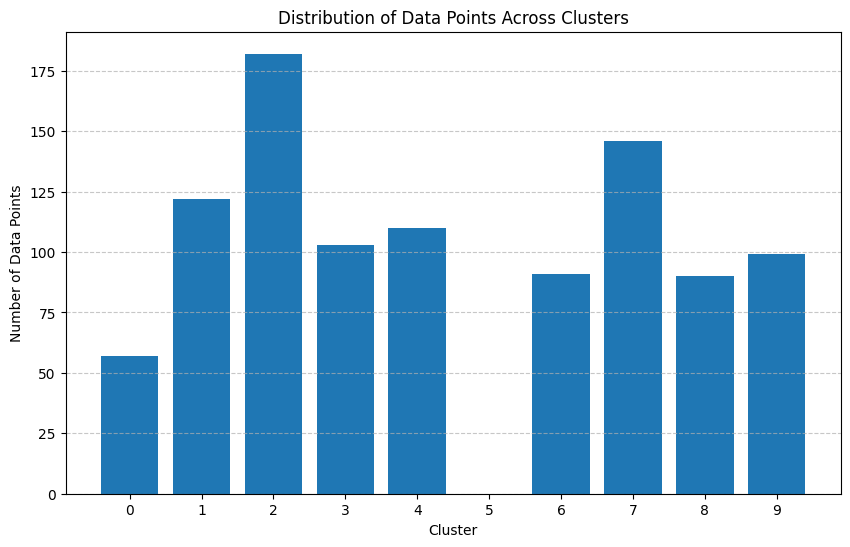

In [25]:
plt.figure(figsize=(10, 6))
# Make sure we have counts for all clusters (0-9)
all_clusters = np.arange(n_clusters)
counts = np.zeros(n_clusters)
for i, count in zip(cluster_counts.index, cluster_counts.values):
    if i < n_clusters:  # Ensure index is within range
        counts[i] = count

plt.bar(all_clusters, counts)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Distribution of Data Points Across Clusters')
plt.xticks(all_clusters)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
centroids_df = pd.DataFrame(kmeans.centroids, columns=feature_names)
centroids_df.index.name = 'Cluster'
print("Cluster Centroids (Standardized Features):")
centroids_df

## Create DataFrames for each cluster
cluster_dfs = {}
for i in range(n_clusters):
    cluster_dfs[i] = data[data['Cluster'] == i].reset_index(drop=True)
    print(f"\nCluster {i} (Showing first 3 rows out of {len(cluster_dfs[i])}):")
    print(cluster_dfs[i].head(3))

Cluster Centroids (Standardized Features):

Cluster 0 (Showing first 3 rows out of 57):
   Age  SiteSpending  SiteTime  RecommendImpression  Education  WorkType  \
0   55        958.61    285.03                   12          2         1   
1   23       4171.08    203.47                   13          1         1   
2   55        403.51    164.41                   15          5         1   

   Gender  Region     Salary  Cluster  
0       0       2   69756.49        0  
1       0       1  107654.15        0  
2       1       1  120167.02        0  

Cluster 1 (Showing first 3 rows out of 122):
   Age  SiteSpending  SiteTime  RecommendImpression  Education  WorkType  \
0   39         40.43    194.19                    4          0         0   
1   49        721.12    247.75                    7          0         0   
2   53        301.13    276.60                    8          0         0   

   Gender  Region    Salary  Cluster  
0       0       3  47015.24        1  
1       0       4 

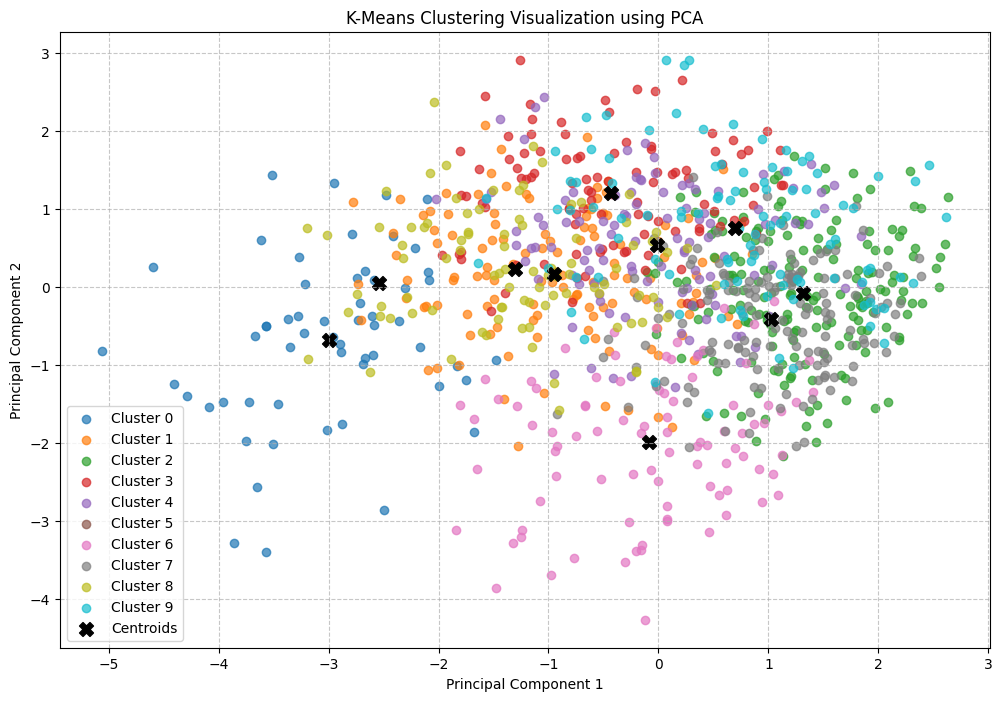

In [27]:
def pca_from_scratch(X, n_components=2):
    # Center the data
    X_centered = X - np.mean(X, axis=0)
    
    # Compute the covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    
    # Select the top n_components eigenvectors
    components = eigenvectors[:, :n_components]
    
    # Project the data onto the principal components
    X_pca = X_centered.dot(components)
    
    return X_pca, components

# Apply PCA to reduce to 2 dimensions for visualization
pca_result, components = pca_from_scratch(scaled_features.values, n_components=2)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels

# Plot the clusters
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.7)

# Project centroids onto PCA space
centroids_centered = kmeans.centroids - np.mean(scaled_features.values, axis=0)
centroids_pca = centroids_centered.dot(components)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='black', marker='X', label='Centroids')

plt.title('K-Means Clustering Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Mean values of features in each cluster:


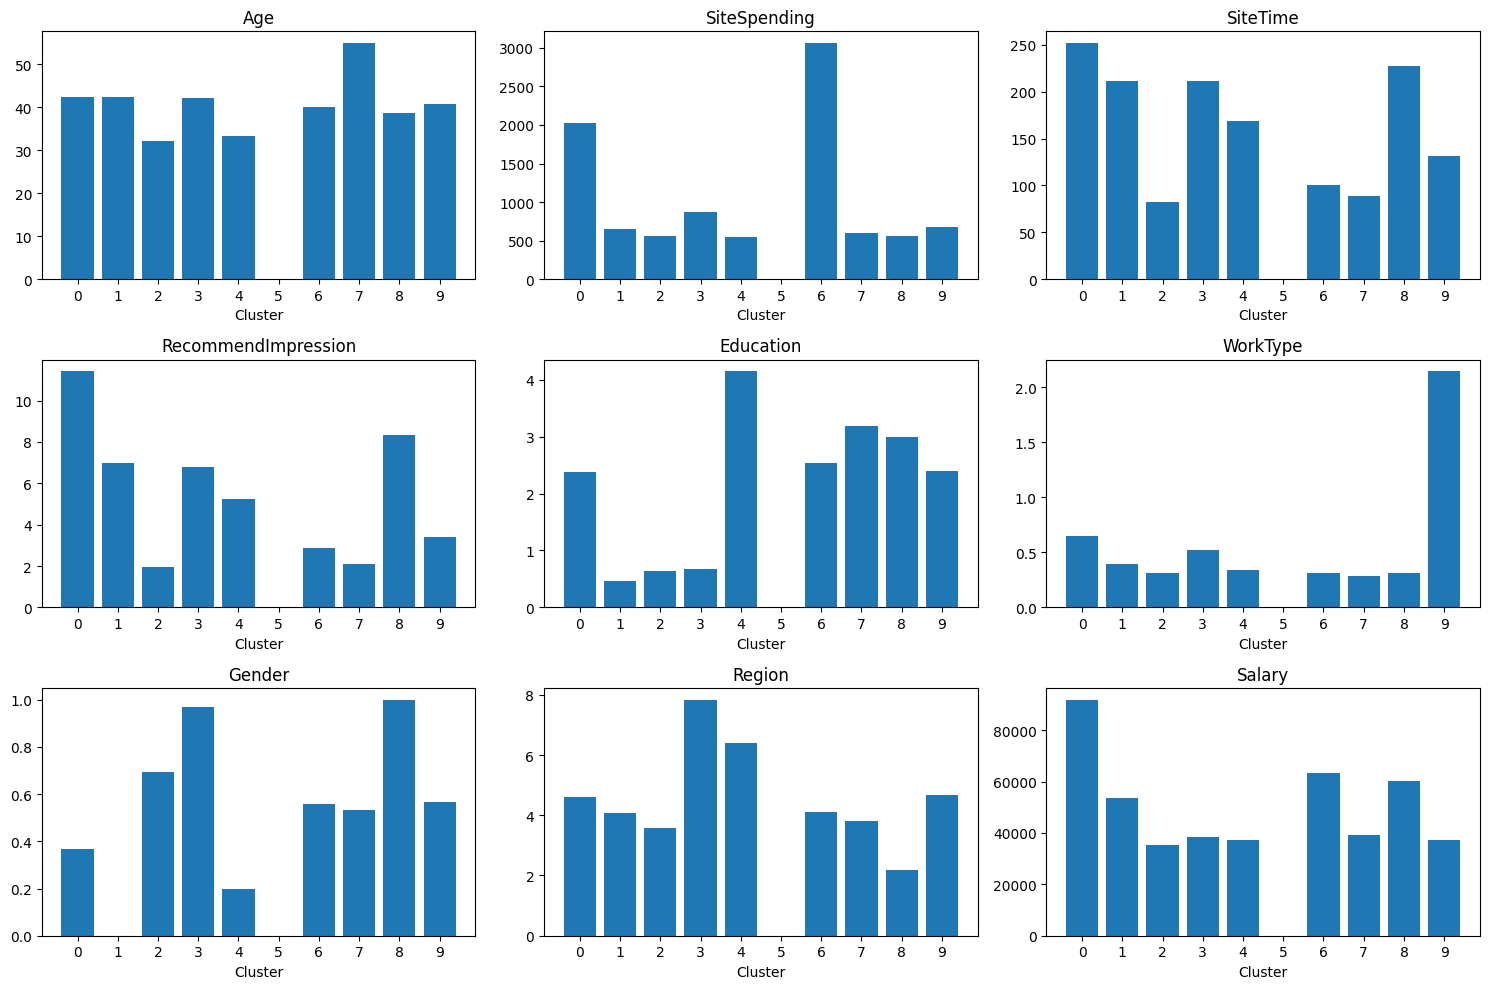

In [28]:
cluster_means = data.groupby('Cluster').mean()
print("Mean values of features in each cluster:")
cluster_means

# Visualize feature means across clusters
plt.figure(figsize=(15, 10))
feature_count = len(feature_names)
rows = (feature_count // 3) + (1 if feature_count % 3 > 0 else 0)
for i, feature in enumerate(feature_names):
    if i < feature_count:  # Safety check
        plt.subplot(rows, 3, i+1)
        # Ensure we have values for all clusters
        values = np.zeros(n_clusters)
        for cluster in range(n_clusters):
            if cluster in cluster_means.index:
                values[cluster] = cluster_means.loc[cluster, feature]
        
        plt.bar(range(n_clusters), values)
        plt.title(feature)
        plt.xlabel('Cluster')
        plt.xticks(range(n_clusters))
plt.tight_layout()
plt.show()